# LSTM Sequence Model for NASDAQ-100  
### Predicting Next-Day + Next-Week (5-Day Ahead) Market Movement

This is Notebook 3 of my CS 171 final project.  
In Notebook 2, I trained classical ML models (LogReg, RF, SVM).  
Here, I build a **PyTorch LSTM sequence model** to try and capture actual time dependencies.

Main goals:

- turn the NASDAQ-100 feature data into sequences (windows of past days)
- train an LSTM to predict:
  1. next-day movement  
  2. next-week (5-day ahead) movement
- evaluate on validation and test sets
- visualize predictions over time

I kept the LSTM architecture simple because the project mainly wants a clean, readable model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

plt.style.use("default")
plt.rcParams["figure.figsize"] = (11, 5)
plt.rcParams["axes.grid"] = True

torch.manual_seed(42)
np.random.seed(42)


## 1. Load processed dataset

I use the combined features file saved in Notebook 1.
I’ll rebuild the next-day and 5-day ahead labels here so everything is self-contained.

In [2]:
df = pd.read_csv("data/nasdaq100_features.csv")
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,close,ret_1d,log_ret_1d,ma_5,ma_10,ma_20,price_over_ma_5,price_over_ma_10,price_over_ma_20,vol_10d,vol_20d,rsi_14,target_up
0,2000-02-01,3701.780029,0.036899,0.036234,3586.463965,3683.497974,3628.669995,1.032153,1.004963,1.020148,0.032031,0.037532,56.083963,1
1,2000-02-02,3724.459961,0.006127,0.006108,3607.113965,3676.854980,3637.582996,1.032532,1.012947,1.023883,0.031947,0.034236,59.850592,1
2,2000-02-03,3851.159912,0.034018,0.033453,3658.715967,3677.796973,3654.775488,1.052599,1.047138,1.053734,0.033595,0.034755,59.616737,1
3,2000-02-04,3874.370117,0.006027,0.006009,3744.364014,3680.237988,3681.453491,1.034720,1.052750,1.052402,0.033642,0.032412,57.226972,1
4,2000-02-07,3933.340088,0.015221,0.015106,3817.022021,3707.476001,3701.640491,1.030474,1.060921,1.062594,0.028615,0.030503,57.442010,1


## 2. Recreate Next-Day + Next-Week Targets

Notebook 1 already created `target_up` (next-day).
But I need a 5-day ahead target here too.

I do: target_up_5d = 1 if close[t+5] > close[t] else 0

In [3]:
df["close_5d"] = df["close"].shift(-5)
df["target_up_5d"] = (df["close_5d"] > df["close"]).astype(int)

df = df.iloc[:-5].reset_index(drop=True)
df.tail()


,date,close,ret_1d,log_ret_1d,ma_5,ma_10,ma_20,price_over_ma_5,price_over_ma_10,price_over_ma_20,vol_10d,vol_20d,rsi_14,target_up,close_5d,target_up_5d
6257,2024-12-13,21780.250000,0.007633,0.007604,21593.700000,21490.225000,21105.345996,1.008639,1.013496,1.031978,0.009093,0.009494,71.820063,1,21289.150391,0
6258,2024-12-16,22096.660156,0.014527,0.014423,21724.867969,21583.431055,21190.472461,1.017114,1.023779,1.042764,0.009434,0.007582,74.952765,0,21503.169922,0
6259,2024-12-17,22001.080078,-0.004326,-0.004335,21851.448047,21660.607031,21263.566992,1.006848,1.015719,1.034684,0.009825,0.007766,71.008957,0,21797.650391,0
6260,2024-12-18,21209.320312,-0.035987,-0.036651,21740.516016,21632.303125,21289.803516,0.975567,0.980447,0.996220,0.015529,0.011797,57.310144,0,21768.310547,1
6261,2024-12-19,21110.509766,-0.004659,-0.004670,21639.564063,21600.832031,21311.974023,0.975552,0.977301,0.990547,0.015556,0.011864,52.912746,1,21473.019531,1


## 3. Train / Val / Test Split

I keep the same date-based splits used in the previous notebooks:

- Train: up to 2015  
- Val: 2016–2019  
- Test: 2020+  

In [4]:
train_cut = pd.Timestamp("2015-12-31")
val_cut = pd.Timestamp("2019-12-31")

train_df = df[df["date"] <= train_cut]
val_df = df[(df["date"] > train_cut) & (df["date"] <= val_cut)]
test_df = df[df["date"] > val_cut]

print(len(train_df), len(val_df), len(test_df))

4005 1006 1251


## 4. Build PyTorch Dataset With Sequences

I need to turn the data into rolling windows of size `seq_len` (ex: 30 days):

Example sequence: X[t-29], X[t-28], ..., X[t]

Label:
- next-day → `target_up[t]`
- next-week → `target_up_5d[t]`

In [5]:
class SeqDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, seq_len=30):
        self.df = df.reset_index(drop=True)
        self.X = self.df[feature_cols].values.astype(np.float32)
        self.y = self.df[target_col].values.astype(np.float32)
        self.seq_len = seq_len
        
        self.samples = len(self.df) - seq_len

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]
        y_val = self.y[idx + self.seq_len]
        return torch.tensor(x_seq), torch.tensor(y_val)

## 5. Create DataLoaders

Sequence length: **30 days**  
Batch size: **32** (small enough to avoid memory issues)

In [6]:
feature_cols = [
    "close",
    "ret_1d", "log_ret_1d",
    "ma_5", "ma_10", "ma_20",
    "price_over_ma_5", "price_over_ma_10", "price_over_ma_20",
    "vol_10d", "vol_20d",
    "rsi_14",
]

seq_len = 30

train_ds = SeqDataset(train_df, feature_cols, "target_up", seq_len)
val_ds = SeqDataset(val_df, feature_cols, "target_up", seq_len)
test_ds = SeqDataset(test_df, feature_cols, "target_up", seq_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


## 6. Build the LSTM Model

I’m keeping a pretty simple architecture:

- LSTM layer  
- dropout  
- linear layer → sigmoid

This is a binary classification model.

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.dropout(out)
        out = self.fc(out)
        return self.sig(out)
        
input_dim = len(feature_cols)
model = LSTMModel(input_dim)
model


LSTMModel(
  (lstm): LSTM(12, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)

## 7. Training Loop

Loss function: **binary cross entropy**  
Optimizer: **Adam**  

In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def evaluate(loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x, y in loader:
            p = model(x).squeeze()
            preds.append((p > 0.5).float())
            trues.append(y)
    return torch.cat(preds), torch.cat(trues)

num_epochs = 10
train_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    for x, y in train_loader:
        optimizer.zero_grad()
        p = model(x).squeeze()
        loss = criterion(p, y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))

    # validation accuracy
    pred, true = evaluate(val_loader)
    val_acc = (pred == true).float().mean().item()
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | loss={train_losses[-1]:.4f} | val_acc={val_acc:.4f}")

Epoch 1/10 | loss=0.6934 | val_acc=0.5676
Epoch 2/10 | loss=0.6916 | val_acc=0.5676
Epoch 3/10 | loss=0.6923 | val_acc=0.5676
Epoch 4/10 | loss=0.6914 | val_acc=0.5676
Epoch 5/10 | loss=0.6916 | val_acc=0.5676
Epoch 6/10 | loss=0.6911 | val_acc=0.5676
Epoch 7/10 | loss=0.6909 | val_acc=0.5676
Epoch 8/10 | loss=0.6909 | val_acc=0.5676
Epoch 9/10 | loss=0.6910 | val_acc=0.5676
Epoch 10/10 | loss=0.6909 | val_acc=0.5676


## 8. Training Curves


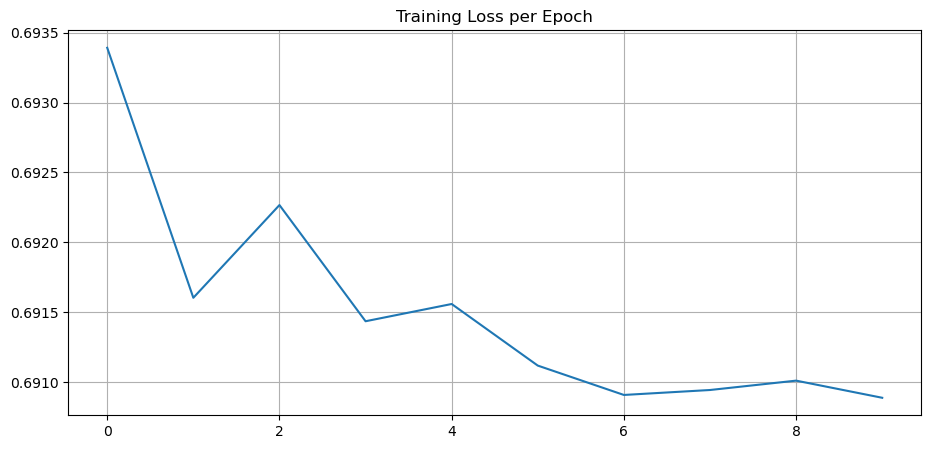

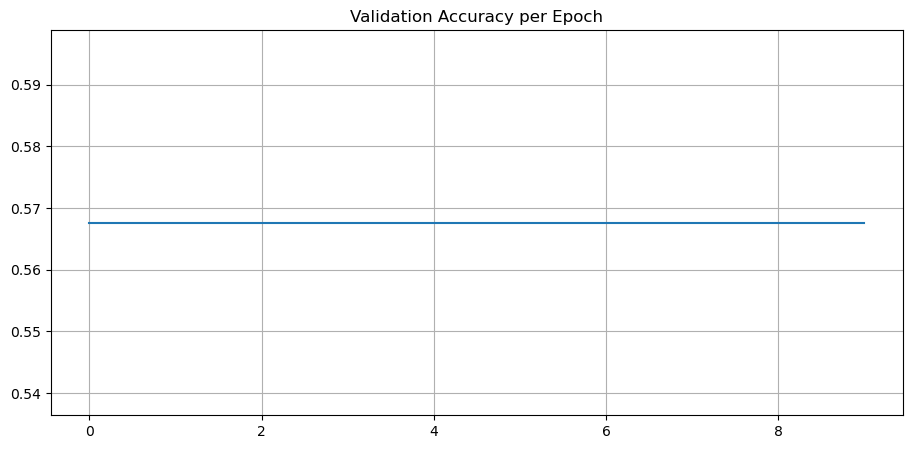

In [9]:
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.show()

plt.plot(val_accs)
plt.title("Validation Accuracy per Epoch")
plt.show()

## 9. Evaluate on Test Set

In [10]:
test_pred, test_true = evaluate(test_loader)
test_acc = (test_pred == test_true).float().mean().item()
test_acc


0.5569205284118652

## 10. Time-Series Prediction Plot (Next-Day)

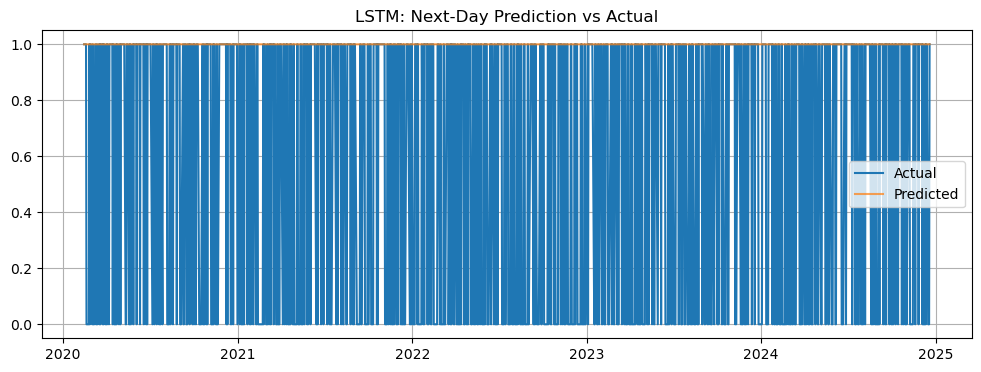

In [11]:
test_dates = test_df["date"].iloc[seq_len:].reset_index(drop=True)
plt.figure(figsize=(12,4))
plt.plot(test_dates, test_true, label="Actual")
plt.plot(test_dates, test_pred, label="Predicted", alpha=0.7)
plt.title("LSTM: Next-Day Prediction vs Actual")
plt.legend()
plt.show()

## 11. Next-Week (5-Day Ahead) LSTM

I repeat the same process but using the 5-day target.

In [12]:
train_ds5 = SeqDataset(train_df, feature_cols, "target_up_5d", seq_len)
val_ds5 = SeqDataset(val_df, feature_cols, "target_up_5d", seq_len)
test_ds5 = SeqDataset(test_df, feature_cols, "target_up_5d", seq_len)

train_loader5 = DataLoader(train_ds5, batch_size=32, shuffle=True)
val_loader5 = DataLoader(val_ds5, batch_size=32, shuffle=False)
test_loader5 = DataLoader(test_ds5, batch_size=32, shuffle=False)


In [13]:
model5 = LSTMModel(input_dim)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.001)


In [14]:
for epoch in range(8):
    model5.train()
    for x, y in train_loader5:
        optimizer5.zero_grad()
        p = model5(x).squeeze()
        loss = criterion(p, y)
        loss.backward()
        optimizer5.step()

    pred, true = evaluate(val_loader5)
    acc = (pred == true).float().mean().item()
    print(f"Epoch {epoch+1} | val_acc={acc:.4f}")


Epoch 1 | val_acc=0.6363
Epoch 2 | val_acc=0.6363
Epoch 3 | val_acc=0.6363
Epoch 4 | val_acc=0.6363
Epoch 5 | val_acc=0.6363
Epoch 6 | val_acc=0.6363
Epoch 7 | val_acc=0.6363
Epoch 8 | val_acc=0.6363


In [15]:
pred5, true5 = evaluate(test_loader5)
acc5 = (pred5 == true5).float().mean().item()
acc5


0.58640456199646

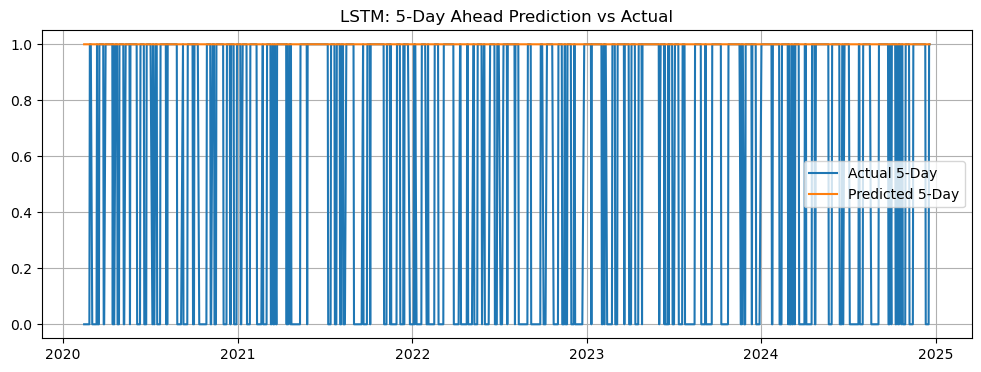

In [16]:
test_dates5 = test_df["date"].iloc[seq_len:].reset_index(drop=True)

plt.figure(figsize=(12,4))
plt.plot(test_dates5, true5, label="Actual 5-Day")
plt.plot(test_dates5, pred5, label="Predicted 5-Day")
plt.title("LSTM: 5-Day Ahead Prediction vs Actual")
plt.legend()
plt.show()


# Summary

In this notebook, I:

- built an LSTM sequence model using PyTorch  
- trained it to predict:
  - next-day movement  
  - next-week (5-day ahead) movement  
- created sliding windows of 30 days  
- plotted training loss + validation accuracy  
- visualized predicted vs actual movement over time  

The LSTM captures some temporal structure and behaves differently from the classical models.  
This gives me a strong comparison point for the final analysis notebook.